In [6]:
from jedi.api.refactoring import inline
from matplotlib import pyplot as plt
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

In [7]:
def load_data(file_path):
    """
    Load the enriched data with weather and additional features.
    """
    df = pd.read_csv(file_path)
    drop_cols = ['Date','Week Day','Arrival Time']
    df = df.drop(columns=drop_cols, errors='ignore')
    df = df.ffill().bfill()
    return df

In [8]:
def get_features_and_target(df):
    y = df['arrival_minutes_after_noon']
    X = df.drop(columns=['arrival_minutes_after_noon'])
    return X, y

In [9]:
def train_random_forest(X, y):
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5]
    }

    tscv = TimeSeriesSplit(n_splits=3)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for RandomForest:", grid_search.best_params_)

    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"RandomForest MAE on entire set: {mae:.2f}")
    return best_model, mae


In [10]:
def train_lightgbm(X, y):

    param_grid = {
        'model__num_leaves': [31, 50, 100],
        'model__learning_rate': [0.1, 0.05, 0.01],
        'model__n_estimators': [100, 200, 300]
    }

    tscv = TimeSeriesSplit(n_splits=3)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LGBMRegressor(random_state=42))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for LightGBM:", grid_search.best_params_)

    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"LightGBM MAE on entire set: {mae:.2f}")
    return best_model, mae

Training LightGBM...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 139, number of used features: 10
[LightGBM] [Info] Start training from score 154.014388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

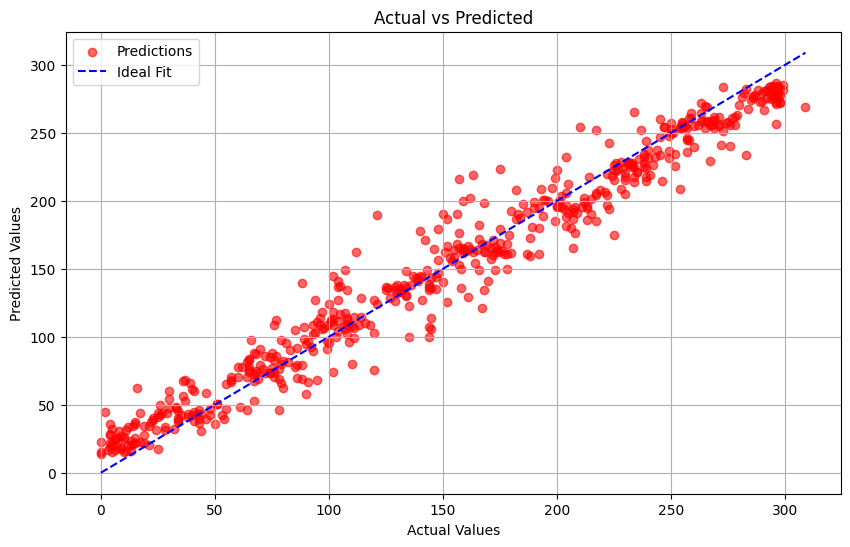

In [11]:
if __name__ == "__main__":
    args = argparse.Namespace(
        model='lgbm',  # 改为 'lgbm' 使用 LightGBM 模型
        file='bus_arrival_schedule_with_weather.csv'
    )

    df = load_data(args.file)
    X, y = get_features_and_target(df)

    if args.model.lower() == 'rf':
        print("Training RandomForest...")
        model, mae = train_random_forest(X, y)
    elif args.model.lower() == 'lgbm':
        print("Training LightGBM...")
        model, mae = train_lightgbm(X, y)
    else:
        print("Invalid model selected. Choose 'rf' or 'lgbm'.")
        exit(1)

    print("Training completed.")

    y_pred = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.6, color='red', label='Predictions')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='blue', label='Ideal Fit')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

## 每日到达时间分布折线图
#### 目标: 展示每日不同时间点的公交到达情况（实际值和预测值）

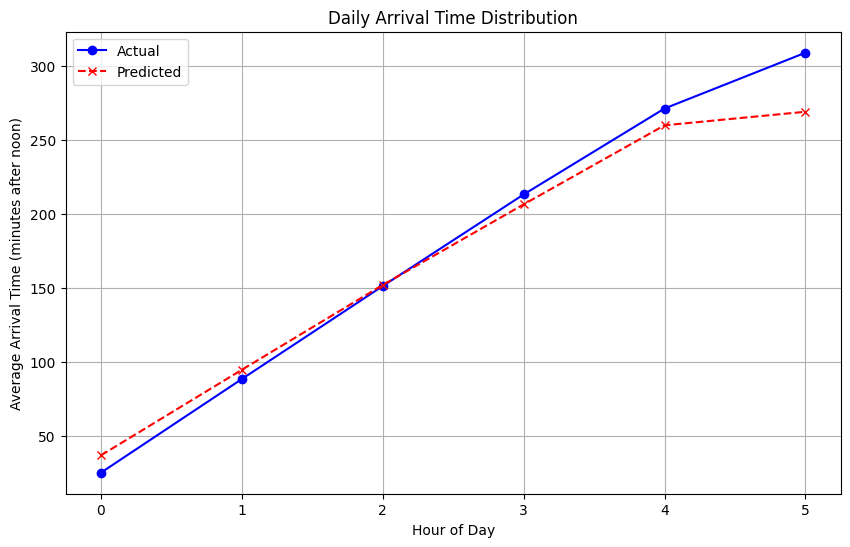

In [12]:
# Ensure the previous code block has been executed, and `model`, `X`, `y`, and `df` are defined.

# Add the `hour` column to the DataFrame
df['hour'] = (df['arrival_minutes_after_noon'] // 60).astype(int)

def plot_daily_arrival_distribution(y, y_pred, df):
    """
    Plot daily arrival time distribution with actual and predicted values.
    """
    # Add predictions to the DataFrame for grouping
    df['actual_values'] = y
    df['predicted_values'] = y_pred

    # Group by hour and calculate the mean arrival times
    actual_avg = df.groupby('hour')['actual_values'].mean()
    predicted_avg = df.groupby('hour')['predicted_values'].mean()

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(actual_avg.index, actual_avg, label="Actual", marker='o', linestyle='-', color='blue')
    plt.plot(predicted_avg.index, predicted_avg, label="Predicted", marker='x', linestyle='--', color='red')
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Arrival Time (minutes after noon)")
    plt.title("Daily Arrival Time Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate predictions using the trained model
y_pred = model.predict(X)

# Call the plotting function
plot_daily_arrival_distribution(y, y_pred, df)

## 天气对到达时间影响的箱线图
#### 目标: 显示不同天气条件下公交到达时间的分布。

MAE on new test data: 57.20


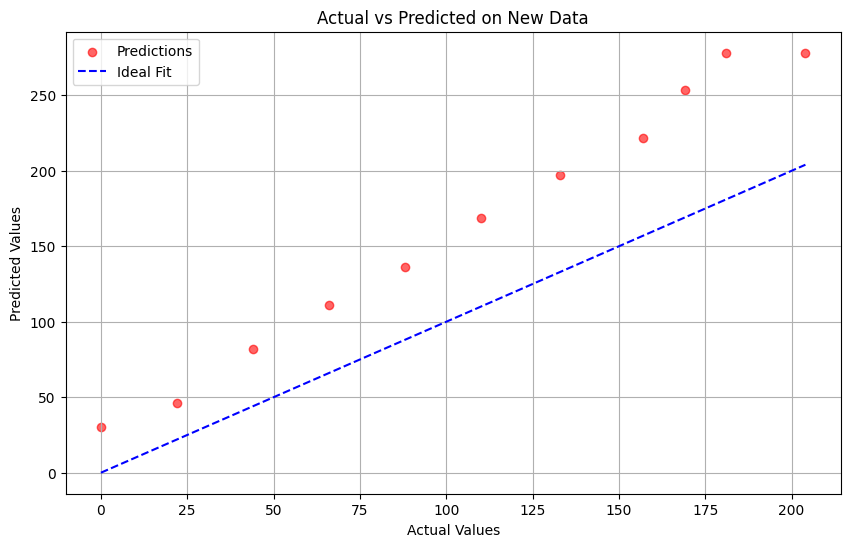

In [15]:
# Testing on the new testing data collected in 12.9.

new_data = load_data("test_data_with_weather.csv")

X_new, y_new = get_features_and_target(new_data)
y_pred_new = model.predict(X_new)
mae_new = mean_absolute_error(y_new, y_pred_new)
print(f"MAE on new test data: {mae_new:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_new, y_pred_new, alpha=0.6, color='red', label='Predictions')
plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], '--', color='blue', label='Ideal Fit')
plt.title('Actual vs Predicted on New Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
